#1 - Implementing the model





In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = True

Loading images

In [2]:
#!pip install fastai --upgrade

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

from matplotlib.colors import ListedColormap
print("Checking existence ",os.chdir(r'/content/drive/MyDrive'))

#image_path = r'/content/drive/MyDrive/carseg_data/images/black_5_doors/no_segmentation'
#segmentation_path = r'/content/drive/MyDrive/carseg_data/images/black_5_doors/with_segmentation'
array_path = r'/content/drive/MyDrive/carseg_data/complete_arrays'
val_array_path = r'/content/drive/MyDrive/carseg_data/val_arrays'
#CMAP for our segmentation according to the colours provided
car_cmap = ListedColormap([
(255,255,255),
(250, 149, 10), (19, 98, 19), (249, 249, 10),
(10, 248, 250), (149, 7, 149), (5, 249, 9),
(20, 19, 249), (249, 9, 250),
(0,0,0)
])

'''
image_files = sorted(os.listdir(image_path))[:1]
segmentation_files = sorted(os.listdir(segmentation_path))[:1]

fig, axs = plt.subplots(2, 1, figsize=(20, 8))
for image_file, segmentation_file in zip(image_files, segmentation_files):
    image_file_path = os.path.join(image_path, image_file)
    segmentation_file_path = os.path.join(segmentation_path, segmentation_file)

    # Load and display the image
    img = Image.open(image_file_path)
    plt.subplot(2, 5, image_files.index(image_file) + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'5 door no seg')

    # Load and display the segmentation mask
    seg_mask = Image.open(segmentation_file_path)
    plt.subplot(2, 5, 5 + image_files.index(image_file) + 1)
    plt.imshow(seg_mask)
    plt.axis('off')
    plt.title(f'5 door seg')

plt.show()
'''

Checking existence  None


"\nimage_files = sorted(os.listdir(image_path))[:1]\nsegmentation_files = sorted(os.listdir(segmentation_path))[:1]\n\nfig, axs = plt.subplots(2, 1, figsize=(20, 8))\nfor image_file, segmentation_file in zip(image_files, segmentation_files):\n    image_file_path = os.path.join(image_path, image_file)\n    segmentation_file_path = os.path.join(segmentation_path, segmentation_file)\n\n    # Load and display the image\n    img = Image.open(image_file_path)\n    plt.subplot(2, 5, image_files.index(image_file) + 1)\n    plt.imshow(img)\n    plt.axis('off')\n    plt.title(f'5 door no seg')\n\n    # Load and display the segmentation mask\n    seg_mask = Image.open(segmentation_file_path)\n    plt.subplot(2, 5, 5 + image_files.index(image_file) + 1)\n    plt.imshow(seg_mask)\n    plt.axis('off')\n    plt.title(f'5 door seg')\n\nplt.show()\n"

##2 - Defining the Dataset and making DataLoaders

In [5]:
class NumpyArrayDataset(Dataset):
    def __init__(self, array_dir):
        self.array_dir = array_dir
        self.array_files = os.listdir(array_dir)

    def __len__(self):
        return len(self.array_files)

    def __getitem__(self, idx):
        array_filename = self.array_files[idx]
        array_path = os.path.join(self.array_dir, array_filename)

        # Load the numpy array
        numpy_array = np.load(array_path)

        # Split the array into RGB and segmentation channels
        rgb_channels = numpy_array[:, :, :3]  # Extract RGB channels
        segm_channel = numpy_array[:, :, 3]   # Extract segmentation channel

        # Convert to PyTorch tensors using transpose and assigning required data types
        rgb_channels_tensor = torch.from_numpy(rgb_channels.transpose(2, 0, 1)).float()
        segm_channel_tensor = torch.from_numpy(segm_channel).long()

        # Return a dictionary containing the RGB and segmentation channels
        return {'car': rgb_channels_tensor, 'segm_mask': segm_channel_tensor}



In [6]:
#Define batch size
batch_size = 3

#Create an instance of the NumpyArrayDataset
numpy_dataset = NumpyArrayDataset(array_path)
val_dataset = NumpyArrayDataset(val_array_path)
#Split into training and validation datasets
#train_dataset_np, val_dataset_np = train_test_split(numpy_dataset, train_size=0.9, random_state=42)

# Create data loaders for the datasets
train_dl_np = DataLoader(numpy_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dl_np = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

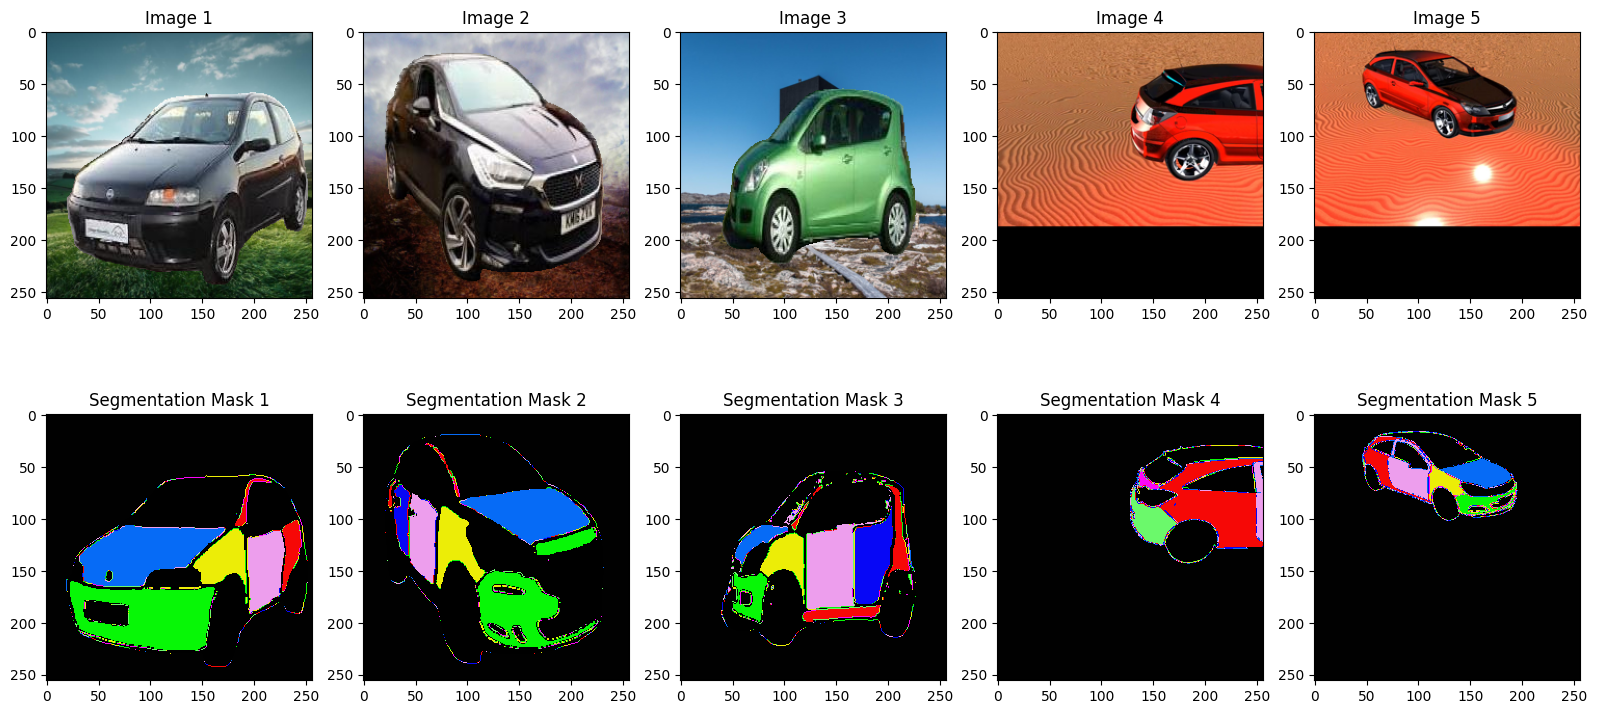

In [7]:

# Display only the first 3 images and segmentation masks
num_images_to_display = 5
fig, axs = plt.subplots(2, num_images_to_display, figsize=(16, 8))

for i in range(num_images_to_display):
    # Get data from the dataset
    data = numpy_dataset[i+ 700*i] # Shuffle manually so we can see different images, as the dataset itself does not shuffle them, the dataloaders do

    # Extract image and segmentation mask data from the dataset
    image_data = data['car'].numpy().transpose(1, 2, 0)
    segmentation_mask = data['segm_mask'].numpy()

    # Display original image
    axs[0, i].set_title(f'Image {i+1}')
    axs[0, i].imshow(image_data.astype(np.uint8))

    # Display segmentation mask using the provided colormap
    axs[1, i].set_title(f'Segmentation Mask {i+1}')
    axs[1, i].imshow(segmentation_mask, cmap=car_cmap)

plt.tight_layout()
plt.show()

# 3 - U-Net implenetation

In [8]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, activation=None ):
        super(ConvLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),nn.LeakyReLU(0.2, inplace=True)
        ]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class TransposeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, flag, kernel_size=4, stride=2, padding=1, bias=False):
        super(TransposeConvLayer, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels)
        ]
        if flag == 1:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        downconv = ConvLayer(input_c, ni)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(inplace=True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = TransposeConvLayer(ni * 2, nf, flag = 1)
            down = [downconv]
            up = [upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = TransposeConvLayer(ni, nf, bias=False, flag = 0)
            down = [downconv]
            up = [upconv, upnorm]
            model = down + up
        else:
            upconv = TransposeConvLayer(ni * 2, nf, bias=False, flag = 0)
            down = [downconv, downnorm]
            up = [upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.2)] #tweak this
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
        self.residual = nn.Sequential(
            nn.Conv2d(input_c, nf, kernel_size=1, stride=1),
            nn.BatchNorm2d(nf)
        )

    def forward(self, x):
        if self.outermost:
            output = self.model(x)
            return output
        else:
            x_clone = x.clone()
            residual_output = self.residual(x_clone)
            model_output = self.model(x)
            concatenated_output = torch.cat([residual_output, model_output], 1)
            return concatenated_output
class Unet(nn.Module):
    def __init__(self, input_c=3, output_c=10, n_down=8, num_filters=64):
        super(Unet, self).__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(3):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        out = self.model(x)
        return  out


## 4 - Weight initialization

In [9]:
def init_weights(net, init='norm', gain=0.1, print_message=True):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

        if 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    if print_message:
        print(f"model initialized with {init} initialization")
    return net

def init_model(model, device, init_type='norm', gain=0.02):
    model = model.to(device)
    model = init_weights(model, init=init_type, gain=gain)
    return model





## 5 - Dice Loss for intermediate testing

In [10]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-8  # Smoothing value to prevent division by zero
        input_flat = input.view(-1)
        target_flat = target.view(-1)
        intersection = (input_flat * target_flat).sum()
        dice_coeff = (2.0 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        dice_loss = 1.0 - dice_coeff
        return dice_loss


## 6 - Main model

In [11]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=0.1,
                 beta1=0.5, beta2=0.999, lambda_L1=1):
        super().__init__()
        self.lr = lr_G
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=3, output_c=10, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)

        self.opt_G = torch.optim.SGD(self.net_G.parameters(), lr=self.lr, momentum=0.9)
        #self.opt_G = optim.Adam(self.net_G.parameters(), lr=self.lr, betas=(beta1, beta2))

        self.LossFunction = nn.CrossEntropyLoss()  # Change loss function for segmentation
        self.LossFunction1 = DiceLoss()
    def set_requires_grad(self, requires_grad=True):
        for p in self.parameters():
            p.requires_grad = True

    def setup_input(self, data):
        self.car = data['car'].to(self.device)
        self.segm_mask = data['segm_mask'].to(self.device)

    def forward(self):

        self.predicted_segm_mask = self.net_G(self.car)

    def backward_G(self):

        self.segm_mask = self.segm_mask / 10
        self.seg_loss = self.LossFunction(self.predicted_segm_mask.type(torch.FloatTensor),self.segm_mask.type(torch.LongTensor))
        self.dice_loss = self.seg_loss
        self.opt_G.zero_grad()
        self.seg_loss.backward()
        self.opt_G.step()

    def optimize(self):
        self.forward()
        self.opt_G.zero_grad()
        self.net_G.train()
        self.backward_G()
        self.opt_G.step()



The MeasureClass class is a utility class for computing and tracking the average of a value over multiple iterations. It keeps track of the count, sum, and average of the values. The reset method resets the meter, while the update method updates the meter with a new value and count.



## 7 - MeasureClass

In [12]:
class MeasureClass:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    seg_loss = MeasureClass()
    dice_loss = MeasureClass()
    return {
            'seg_loss': seg_loss,
            'dice_loss': dice_loss}

def update_losses(model, loss_meter_dict, count, writer, step):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        writer.add_scalar(loss_name, loss_meter.avg, step)

def log_results(loss_meter_dict, step, writer, num_epoch):
    for loss_name, loss_meter in loss_meter_dict.items():
        l_avg = loss_meter.avg
        #print(f"{loss_name}: {l_avg:.5f}")
        writer.add_scalar(loss_name, loss_meter.avg, step)

def plot_results(loss_list, num_epochs):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), loss_list, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Total Loss Over Epochs')
    plt.legend()
    plt.show()

## 8 - Training the model

model initialized with norm initialization
Epoch  1


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  1
1.654443393472183 99.998
1.654443393472183 1.654443393472183


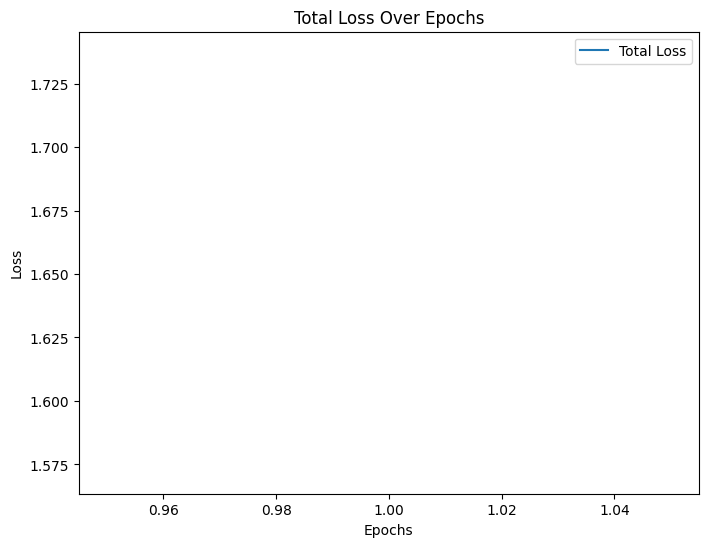

Epoch  2


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  2
1.5807975868173239 1.652443393472183
1.5807975868173239 1.5807975868173239


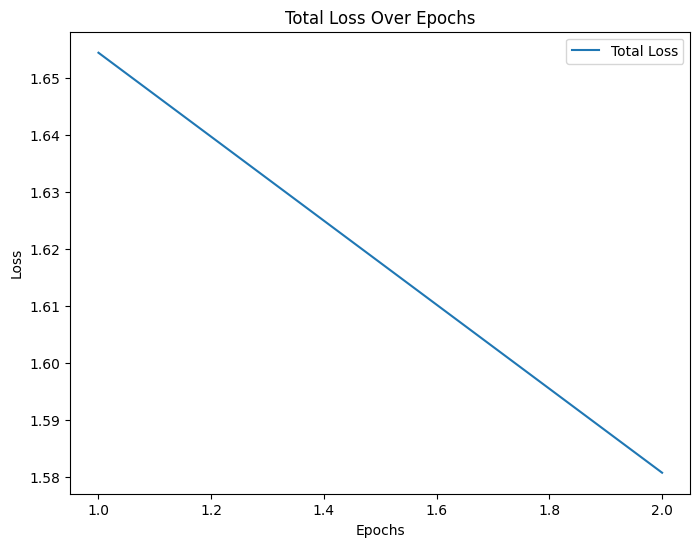

Epoch  3


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  3
1.5587503848788318 1.5787975868173239
1.5587503848788318 1.5587503848788318


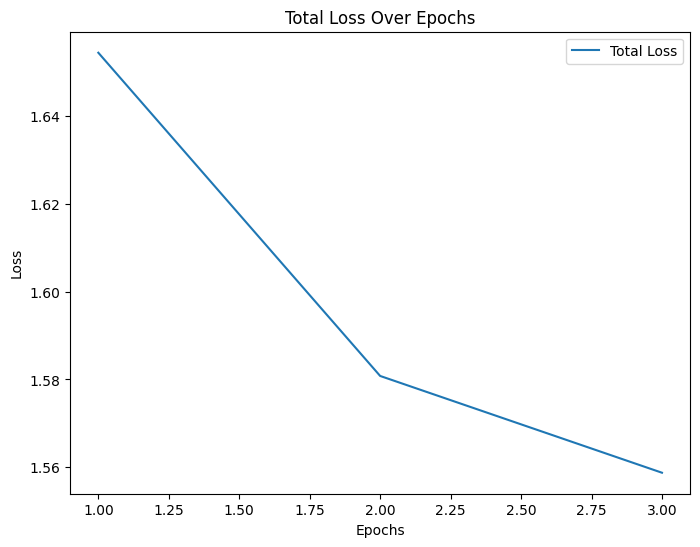

Epoch  4


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  4
1.552441716186884 1.5567503848788318
1.552441716186884 1.552441716186884


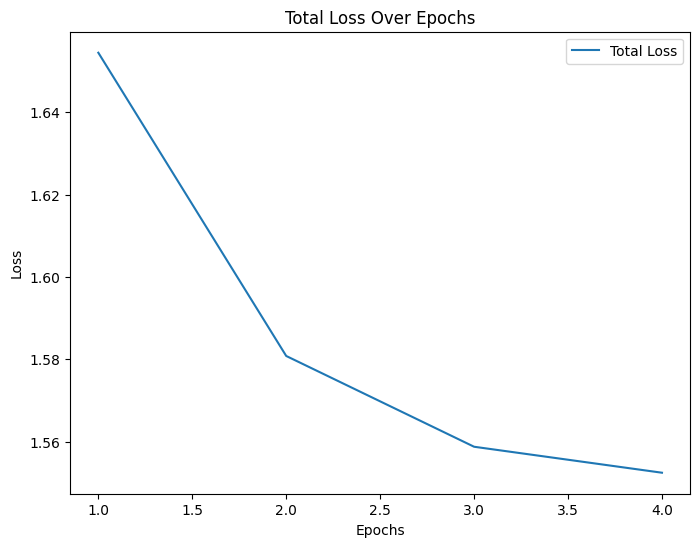

Epoch  5


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  5
1.5427649010103521 1.550441716186884
1.5427649010103521 1.5427649010103521
0.01


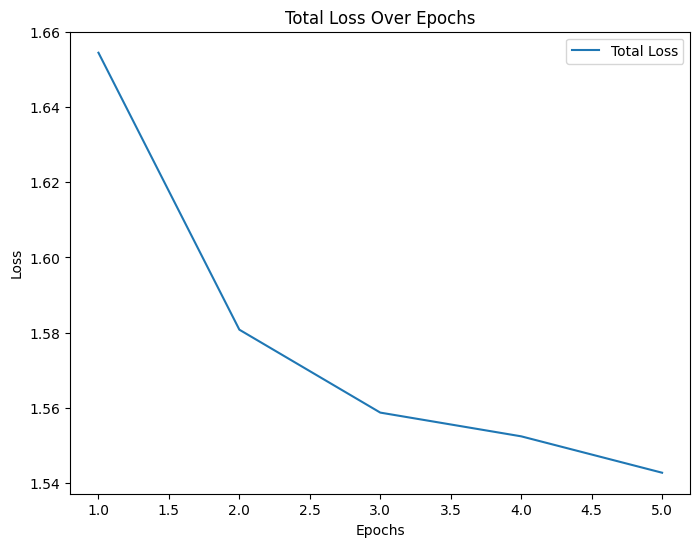

Epoch  6


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  6
1.5418385842597373 1.5407649010103521


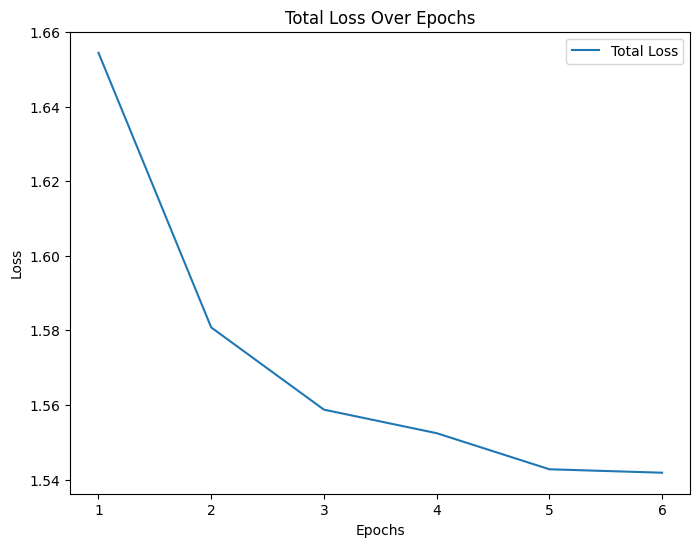

Epoch  7


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  7
1.5382126804440936 1.5407649010103521
1.5382126804440936 1.5382126804440936


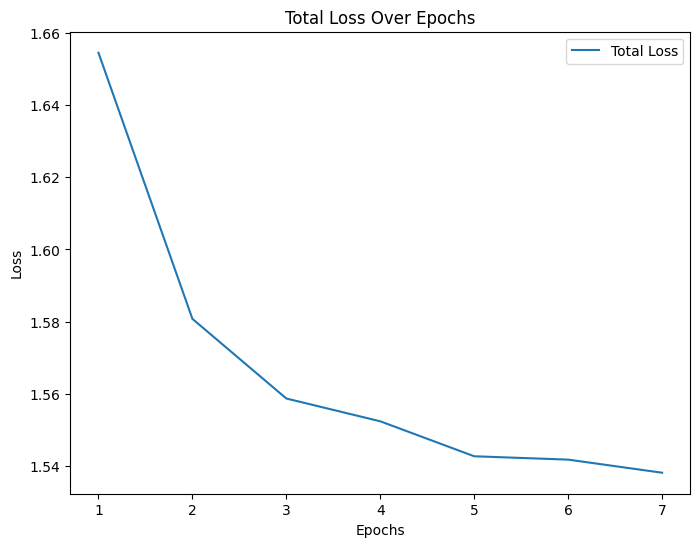

Epoch  8


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  8
1.5383474839432423 1.5362126804440936


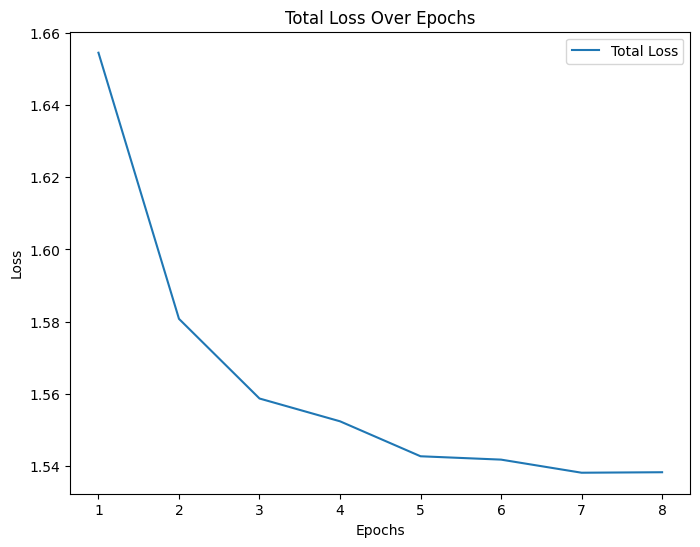

Epoch  9


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  9
1.5374478987637392 1.5362126804440936


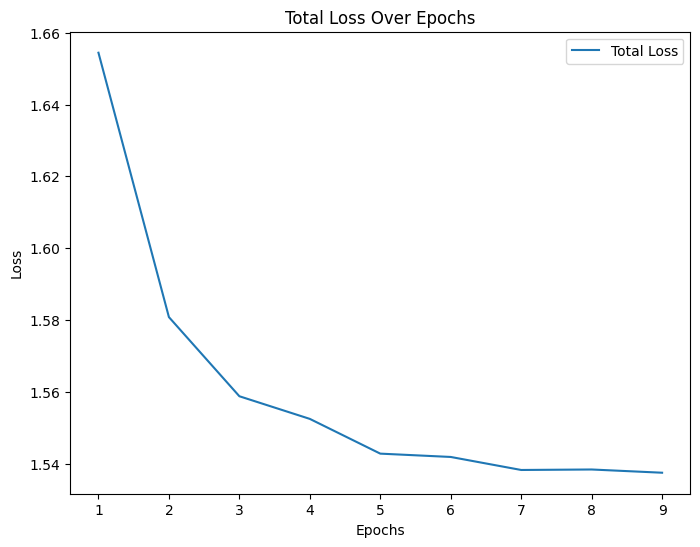

Epoch  10


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  10
1.5381295138667277 1.5362126804440936
Adjusting learning rate
0.0005


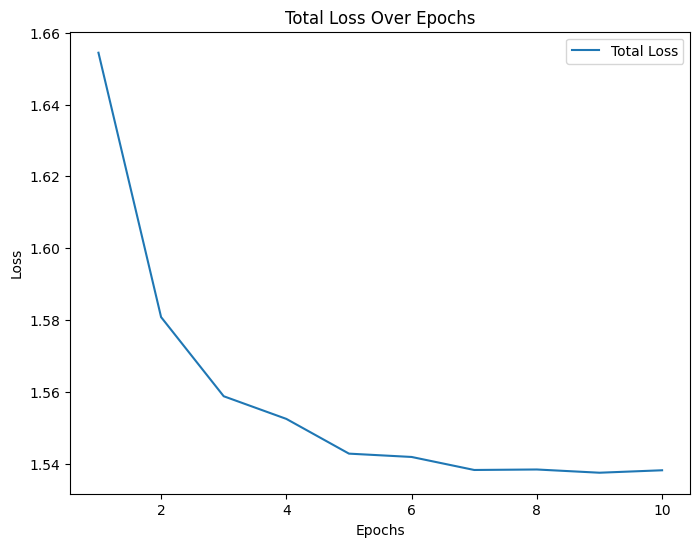

Epoch  11


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  11
1.5371679661147384 1.5362126804440936


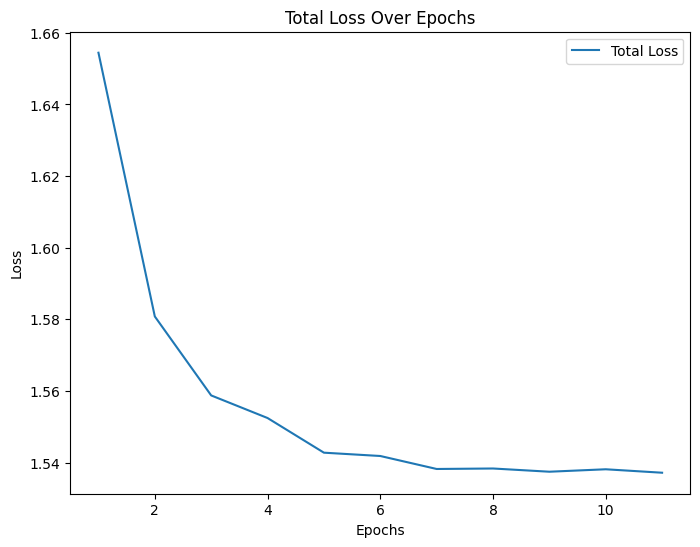

Epoch  12


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  12
1.536672538577678 1.5362126804440936


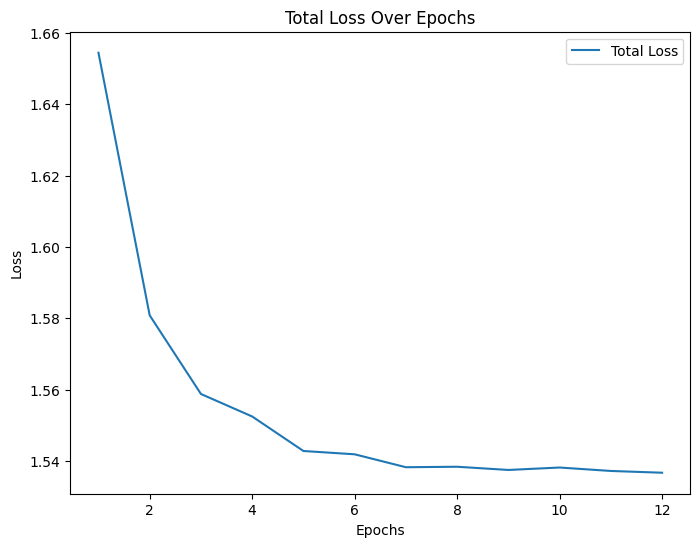

Epoch  13


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  13
1.535376227872903 1.5362126804440936
Adjusting learning rate


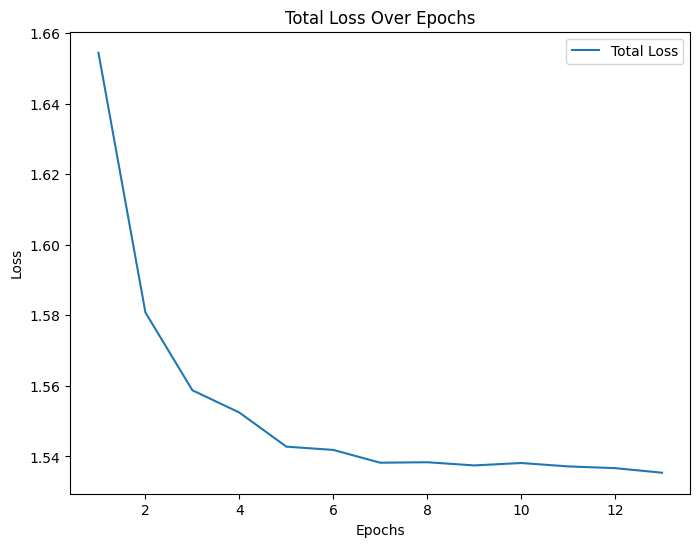

Epoch  14


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  14
1.5365801373784438 1.5362126804440936


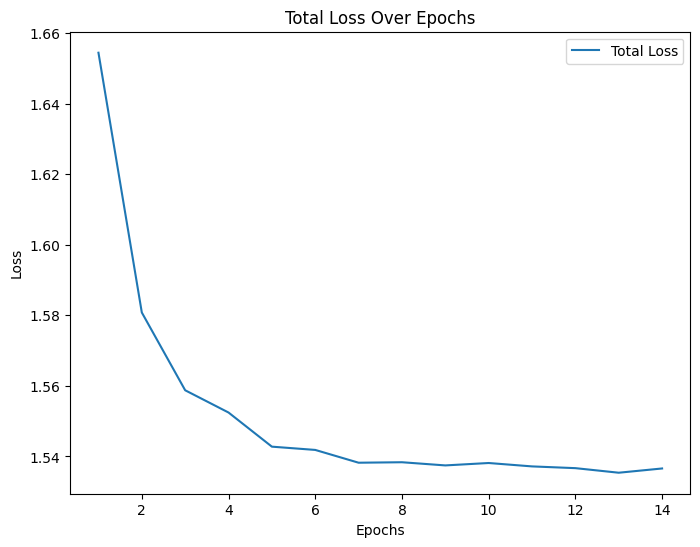

Epoch  15


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  15
1.5373238374837803 1.5362126804440936
2.5e-05


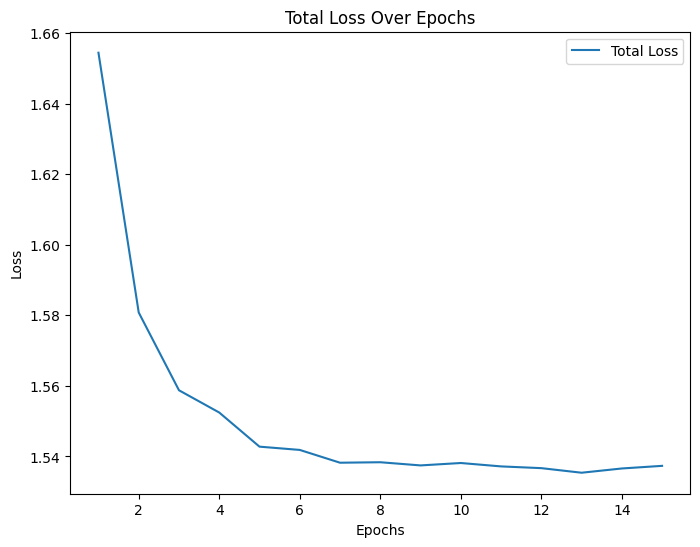

Epoch  16


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  16
1.5349130655220642 1.5362126804440936
1.5349130655220642 1.5349130655220642


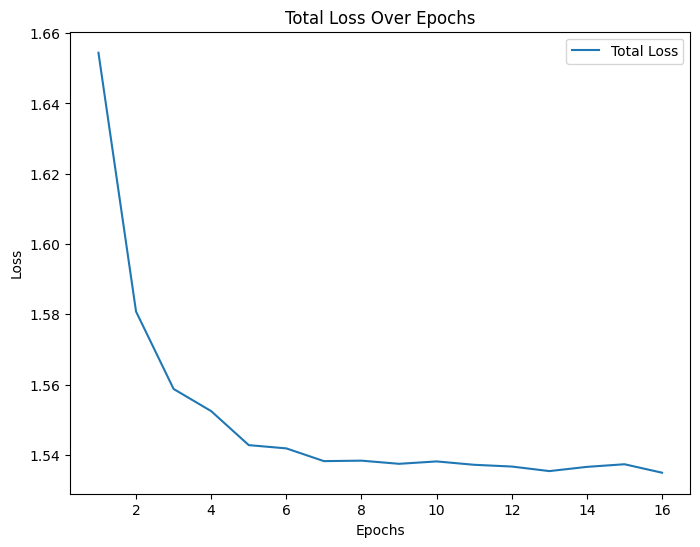

Epoch  17


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  17
1.5373528438652757 1.5329130655220642


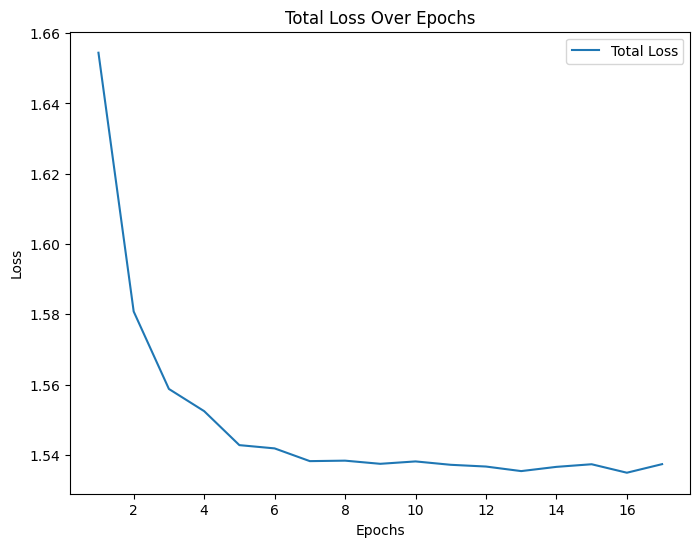

Epoch  18


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  18
1.5352634794106257 1.5329130655220642


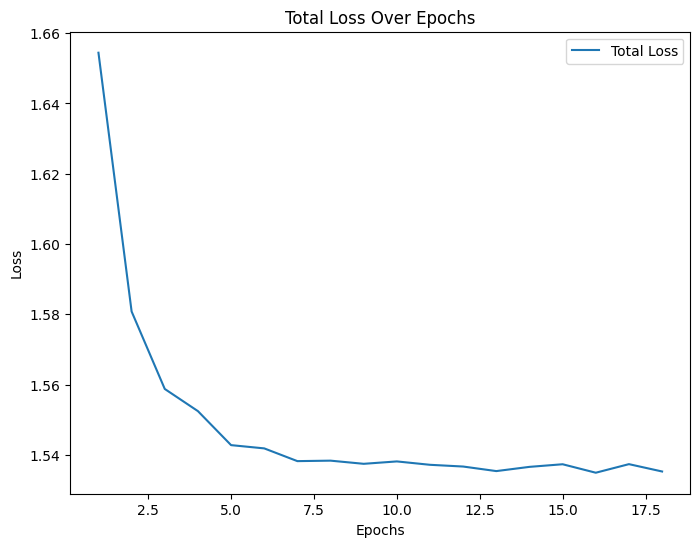

Epoch  19


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  19
1.5360244774426892 1.5329130655220642
Adjusting learning rate


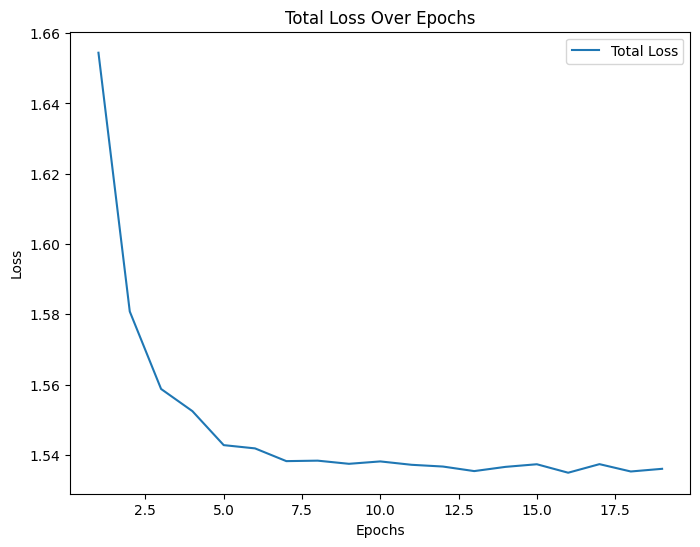

Epoch  20


  0%|          | 0/1541 [00:00<?, ?it/s]

Epoch  20
1.5345823554791598 1.5329130655220642
1.25e-06


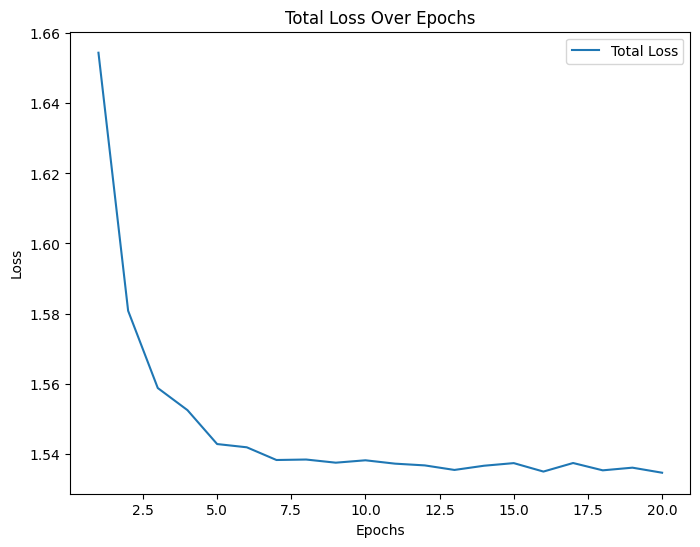

Epoch  21


  0%|          | 0/1541 [00:00<?, ?it/s]

In [ ]:
loss_list = [] #For plotting the loss

def train_model(model, train_loader, epochs):
    writer = SummaryWriter()
    step = 0
    total_losses = []
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience = 3,verbose = True)
    best_loss = 100
    counter = 0
    lr_ctr = 0
    for epoch in range(1, epochs + 1):

        print('Epoch ', epoch)
        loss_meter_dict = create_loss_meters()
        i = 0
        avg_loss_list = []
        for data in tqdm(train_loader):
            model.set_requires_grad()
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['car'].size(0), writer=writer, step=step)
            i += 1
            step += 1
            for loss_name, loss_meter in loss_meter_dict.items():
                l_avg = loss_meter.avg
            avg_loss_list.append(l_avg)
            log_results(loss_meter_dict, step, writer, epoch)
        loss_epoch = sum(avg_loss_list)/len(avg_loss_list)
        loss_list.append(loss_epoch)
        print('Epoch ', epoch)
        lr_ctr+=1
        patience = 3
        print(loss_epoch, best_loss - 0.002)
        if loss_epoch < best_loss - 0.003:
            best_loss = loss_epoch
            print(best_loss, loss_epoch)
            counter = 0  # Reset counter
        else:
            counter += 1

        if counter >= patience:
            print(f'Adjusting learning rate')
            model.lr = model.lr/2
            counter = 0
        if lr_ctr == 5:
          lr_ctr = 0
          model.lr = model.lr/10
          model.opt_G = torch.optim.SGD(model.parameters(), lr=model.lr, momentum=0.9)
          print(model.lr)
        plot_results(loss_list, epoch)
    writer.close()


model = MainModel()
num_epochs = 35
train_model(model, train_dl_np, num_epochs)

plot_results(loss_list, num_epochs)

## 9 - Visualisation of the results

In [ ]:
def visualize_segmentation(model, valid_dl, num_samples=5):
    model.eval()

    vis_iterator = iter(valid_dl)

    for j in range(9):
      print('s')
      data = next(vis_iterator)
      for i in range(2):
          car_scans = data['car'][i].cpu().numpy()

          # Forward pass
          model.car = data['car'].cuda()
          model.forward()
          segms = data['segm_mask'][i].cpu().numpy()

          # Get predicted segmentation
          predicted_masks = model.predicted_segm_mask[i].cpu().detach().numpy()

          plt.figure(figsize=(12, 4))

          # Display the original car image
          plt.subplot(1, 3, 1)
          plt.title('Car image')
          plt.imshow(car_scans.transpose(1,2,0).astype(np.uint8))
          plt.axis('off')

          # Display the actual segmentation
          plt.subplot(1, 3, 2)
          plt.title('Actual segmentation')
          plt.imshow(segms,cmap=car_cmap)
          plt.colorbar()
          plt.axis('off')

          # Display the predicted segmentation mask
          plt.subplot(1, 3, 3)
          plt.title('Predicted segmentation')
          predicted_masks = np.argmax(predicted_masks,axis = 0)*10
          plt.imshow(predicted_masks,cmap=car_cmap)
          plt.axis('on')
          plt.colorbar()
          plt.tight_layout()
          plt.show()


visualize_segmentation(model, val_dl_np, num_samples=5)

